## Problem 1

In [1]:
import io
import requests
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set up data matrix
url = "https://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/zip.digits/train.0"
source = requests.get(url)
X = np.array([np.array(x[:-1].split(',')).astype('float32')
    for x in io.StringIO(source.content.decode('utf-8')).readlines()])

In [3]:
# Compute sample mean and centralise
sample_mean = X.mean(axis=0)
tilde_X = X - sample_mean

In [11]:
from sklearn.decomposition import PCA

# Compute the top k components
k = 20
pca = PCA(n_components=k)
pca.fit(tilde_X)

PCA(n_components=20)

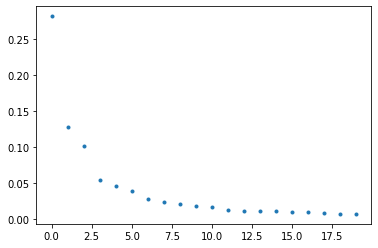

In [12]:
# Eigenvalue curve
plt.plot(pca.explained_variance_ratio_,'.')

In [13]:
# mean and principle components
U = pca.components_
U.shape

(20, 256)

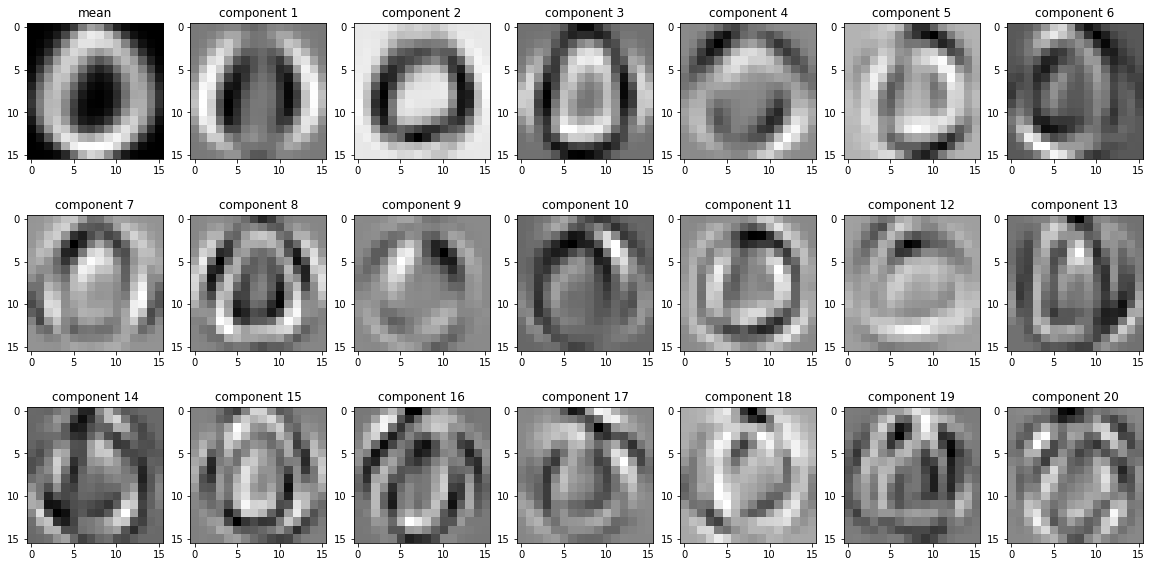

In [14]:
fig,ax=plt.subplots(3, 7, figsize=(20, 10))
ax[0][0].imshow(sample_mean.reshape(16, -1),cmap='gray')
ax[0][0].set_title('mean')
for j in range(k):
    row = (j + 1) // 7
    col = (j + 1) % 7
    ax[row][col].imshow(U[j,:].reshape(16, -1),cmap='gray')
    ax[row][col].set_title('component '+str(j+1))

In [15]:
# Ordering image according to the fisrt component
V = pca.transform(X)
order = np.argsort(V[:,0])

In [16]:
X[order].shape

(1194, 256)

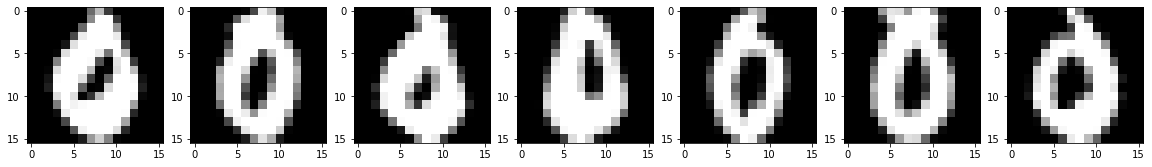

In [17]:
fig,ax=plt.subplots(1,7,figsize=(20,10))
for j in range(7):
    ax[j].imshow(X[order][j,:].reshape(16,-1),cmap='gray')

In [18]:
# Scattering first two components
grid_x = np.arange(-6,8,2)
grid_y = np.arange(-6,4,2)
grid_index = [
    np.argmin(np.abs(V[:,0]-x)+np.abs(V[:,1]-y))
    for x in grid_x
    for y in grid_y
]

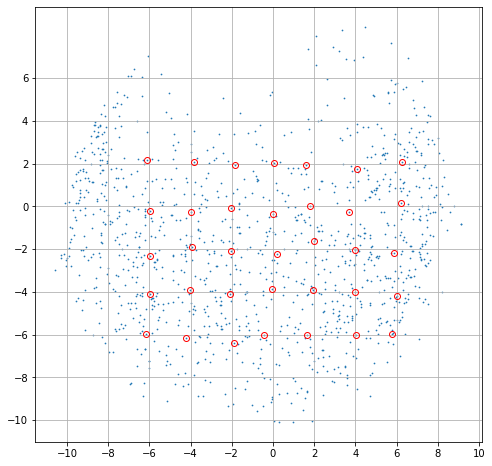

In [19]:
fig,ax = plt.subplots(1,figsize=(8,8))
ax.set_xticks(np.arange(-10,12,2))
ax.set_yticks(np.arange(-10,8,2))
ax.grid()
ax.plot(V[grid_index,0],V[grid_index,1],'ro',mfc='none')
ax.scatter(V[:,0],V[:,1],s=0.5)

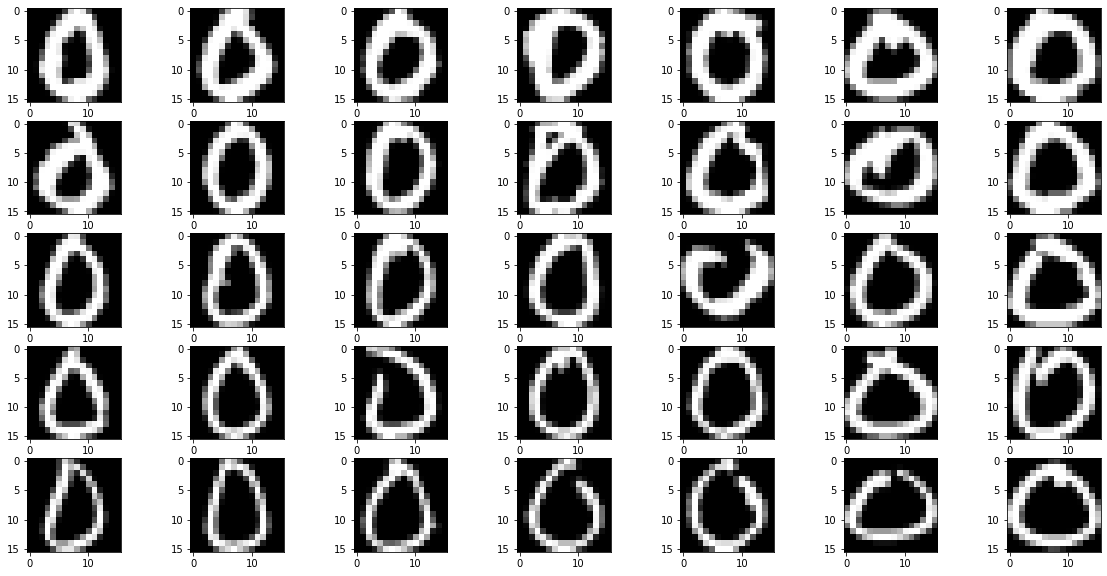

In [20]:
fig,ax = plt.subplots(5,7,figsize=(20, 10))
for i in range(7):
    for j in range(4,-1,-1):
        index = grid_index[j+i*5]
        ax[j][i].imshow(X[index,:].reshape(16,-1),cmap='gray')

## Problem 2

In [67]:
# Cities
cities = ["Hong Kong", "Shanghai", "New York", "Amsterdam", "London", "Tokyo", "Singapore"]

In [68]:
# Fetch distances between two cities.
from geopy.geocoders import Nominatim
from geopy import distance
geolocator = Nominatim(user_agent="Safari")

def get_coordinates(city):    
    loc = geolocator.geocode(city)
    return (loc.latitude, loc.longitude)

def get_distance(city1, city2):
    coo1 = get_coordinates(city1)
    coo2 = get_coordinates(city2)
    print("Getting distance between", city1, "and", city2 + ".")
    return distance.distance(coo1, coo2).km

In [69]:
# Compute D, the matrix of squares of distances
import pandas as pd
import itertools
D = pd.DataFrame(columns=cities, index=cities, dtype=float)
for pair in itertools.product(cities, cities):
    D.loc[pair[0], pair[1]] = get_distance(pair[0], pair[1]) ** 2

Getting distance between Hong Kong and Hong Kong.
Getting distance between Hong Kong and Shanghai.
Getting distance between Hong Kong and New York.
Getting distance between Hong Kong and Amsterdam.
Getting distance between Hong Kong and London.
Getting distance between Hong Kong and Tokyo.
Getting distance between Hong Kong and Singapore.
Getting distance between Shanghai and Hong Kong.
Getting distance between Shanghai and Shanghai.
Getting distance between Shanghai and New York.
Getting distance between Shanghai and Amsterdam.
Getting distance between Shanghai and London.
Getting distance between Shanghai and Tokyo.
Getting distance between Shanghai and Singapore.
Getting distance between New York and Hong Kong.
Getting distance between New York and Shanghai.
Getting distance between New York and New York.
Getting distance between New York and Amsterdam.
Getting distance between New York and London.
Getting distance between New York and Tokyo.
Getting distance between New York and Si

In [70]:
D

,Hong Kong,Shanghai,New York,Amsterdam,London,Tokyo,Singapore
Hong Kong,0.000000e+00,1.510189e+06,1.684748e+08,8.642736e+07,9.298708e+07,8.350453e+06,6.612090e+06
Shanghai,1.510189e+06,0.000000e+00,1.411736e+08,7.908895e+07,8.495411e+07,3.124169e+06,1.438806e+07
New York,1.684748e+08,1.411736e+08,0.000000e+00,3.455371e+07,3.119504e+07,1.181759e+08,2.353167e+08
Amsterdam,8.642736e+07,7.908895e+07,3.455371e+07,0.000000e+00,1.284509e+05,8.676362e+07,1.101490e+08
London,9.298708e+07,8.495411e+07,3.119504e+07,1.284509e+05,0.000000e+00,9.188095e+07,1.177640e+08
Tokyo,8.350453e+06,3.124169e+06,1.181759e+08,8.676362e+07,9.188095e+07,0.000000e+00,2.820798e+07
Singapore,6.612090e+06,1.438806e+07,2.353167e+08,1.101490e+08,1.177640e+08,2.820798e+07,0.000000e+00


In [71]:
def MDS(D, k):
    n = D.shape[0]
    # Compute centering matrix
    H = np.identity(n) -1 / n * np.ones((n, n))
    # Compute B
    B = -1/2 * np.matmul(np.matmul(H, (D**2).to_numpy()), H.T)
    # Compute eigenvalues and eigenvectors in descending order
    ei_val, ei_vec = np.linalg.eigh(B)
    ei_val = np.flip(ei_val)
    ei_vec = np.flip(ei_vec)
    # Diag matrix of eigenvalues
    Lambda = np.diag(ei_val[:k])
    return np.matmul(ei_vec[:k].T, Lambda ** (1/2)), ei_val

In [72]:
coo, ei_val = MDS(D, 2)
coo,ei_val

(array([[-1.05056359e+08, -7.09843400e+06],
        [ 5.47382159e+07, -3.70828992e+07],
        [ 7.05247606e+07,  2.26345097e+07],
        [ 2.05852104e+07, -3.38829697e+06],
        [ 1.46427647e+07, -6.39421967e+06],
        [ 6.16662443e+07,  3.39622759e+07],
        [-1.06622949e+08,  2.10379231e+07]]),
 array([ 3.48161930e+16,  3.58624720e+15,  3.75817172e-01, -2.66492568e+12,
        -1.82129818e+13, -2.44747768e+14, -1.06356287e+16]))

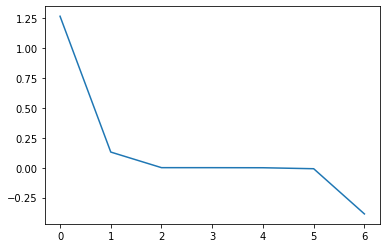

In [73]:
plt.plot(ei_val / ei_val.sum())

There are 4 negative eigenvalues, which means that the original distances are not Euclidean. 

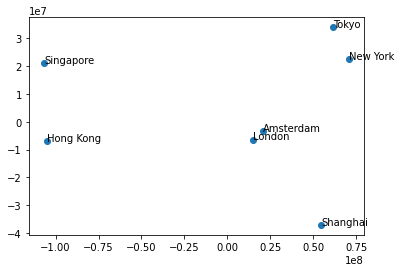

In [74]:
# Use 2 eigenvectors
_, ax = plt.subplots()
ax.scatter(coo[:, 0], coo[:, 1])

for i, txt in enumerate(D.index):
    ax.annotate(txt, (coo[i, 0], coo[i, 1]))

In [75]:
# Use 3 eigenvectors

coo, _ = MDS(D, 3)

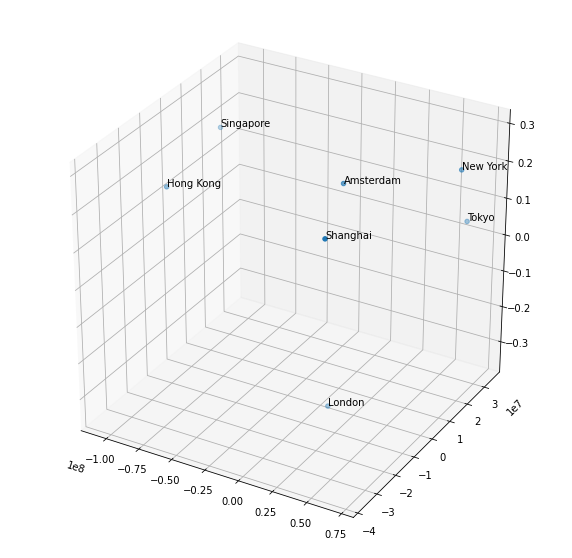

In [76]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coo[:, 0], coo[:, 1], coo[:, 2])

for i, txt in enumerate(D.index):
    ax.text(coo[i, 0], coo[i, 1], coo[i, 2], txt)